# Well Tempered Data

## Weather Analysis Visualization

### Part 2: Explore plot options for 1 year of data

In [1]:
import os
import sys
from dotenv import load_dotenv

project_dir = os.path.join(os.pardir, os.pardir)

# add local python functions
sys.path.append(os.path.join(project_dir, "src"))

# get darksky.io API KEY end other keys from `~/.env`
load_dotenv(os.path.join(os.path.expanduser('~'), ".env"))

True

In [2]:
import pandas as pd
import numpy as np
import json
from datetime import date, datetime

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # retina display

mpl.style.use('seaborn-whitegrid')
style_fn = os.path.join(project_dir, 'src', 'visualization', 'display.mplstyle')
plt.style.use(style_fn)

Specify when notebook was run, and with which packages. Specially useful for nbview, blog posts, and other media where the notebook is not being shared as executable code.

In [3]:
%load_ext watermark
%watermark -a "J. Bruno Morgado" -d -t -v -p numpy,pandas,matplotlib,seaborn -g

J. Bruno Morgado 2016-11-24 20:01:40 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
pandas 0.19.1
matplotlib 1.5.3
seaborn 0.7.1
Git hash: 49a46cb436b1cd4775aebf8af26b8cd7c069c966


## Import raw data and convert it to usable format
- Import the raw data we obtained from *Dark Sky APi* stored in JSON format.
- With `geopy` get the timezone of the data using the `latitude` and `logitude` fields in the JSON data.
- Extract the `hourly` and `daily` data from the JSON and import it into `pandas`.

In [4]:
import glob
import re

def get_observations(year, location, key):
    """ Takes the year, location and target key and returns
        a pandas dataframe with the observations.
        
        :param int year: Observation year
        :param str location: Observation location
        :param str key: Dictionary key
        :returns pandas.DataFrame: Weather observations
    """
    obs_folder = os.path.normpath(os.path.join(project_dir,
                                               'data',
                                               'raw',
                                               location,
                                               str(year)))
    year_pattern = os.path.join(obs_folder, '*.json')
    year_files = glob.glob(year_pattern)

    # read observation json files
    observations = []
    for fn in year_files:
        with open(fn, 'r') as fp:
            raw_obs = fp.read()
            json_obs = json.loads(raw_obs)

            # import data to pandas
            key_data = json_obs[key]['data']
            observations.append(pd.io.json.json_normalize(key_data))
                
    observations = pd.concat(observations)
    
    time_zone = json_obs['timezone']
    
    # transform all timestamps into datetime
    columns = []
    regex_expression = "(.+|)[tT]ime"
    for column in observations.columns:
        columns.append(str(column))
    time_columns = [m.group(0) for l in columns for m in [re.fullmatch(regex_expression, l)] if m]
    for column in time_columns:
        observations[column] = pd.to_datetime(observations[column], unit='s', infer_datetime_format=True).dt.tz_localize('UTC').dt.tz_convert(time_zone)
        
    # set the dataframe index to the time column
    observations.set_index('time', inplace=True)
    observations.sort_index(inplace=True)

    return observations

In [5]:
hourly = get_observations(2015, 'Porto, Portugal', 'hourly')
daily = get_observations(2015, 'Porto, Portugal', 'daily')

## Plot the data

Now that we have the data in a format easily readable by pandas, we can plot it.

### Plot the temperatures

The maximum temperature is under the key `temperatureMax` and the minumum temperature under the key `temperatureMin`.

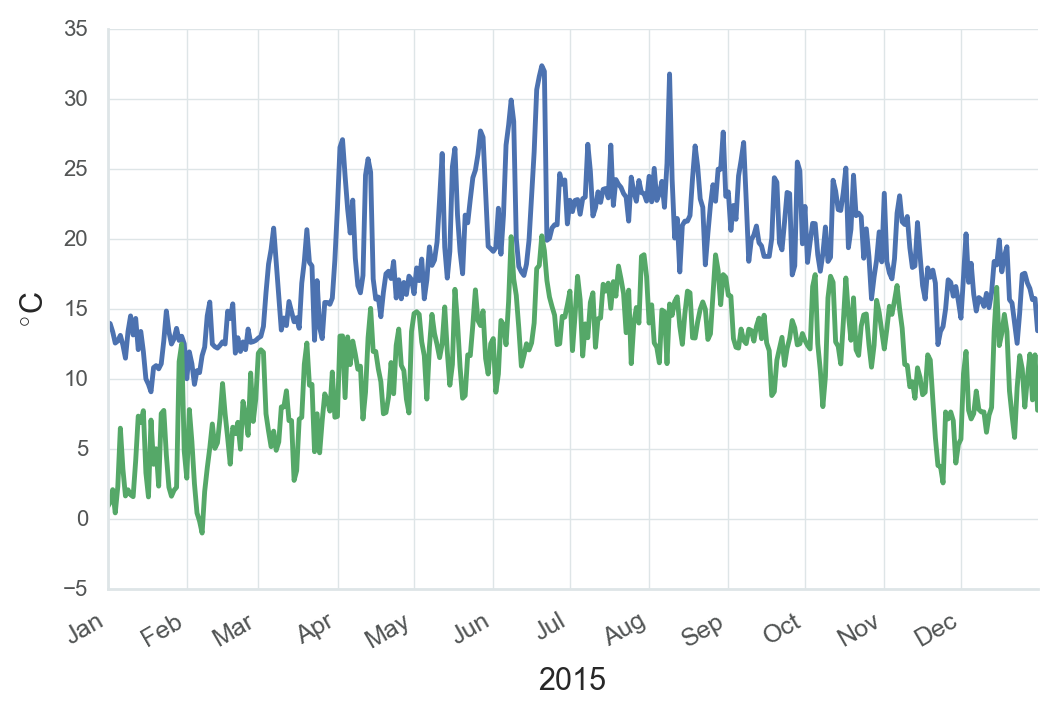

In [6]:
fig, ax = plt.subplots(1)

# visuals
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)  
ax.grid(True)

ax.plot(daily.temperatureMax)
ax.plot(daily.temperatureMin)
fig.autofmt_xdate() # auto rotate the x labels if needed
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('2015')
ax.set_ylabel('$^{\circ}$C')
plt.show()

### Plot the precipitation

The precipitation is given by the key `precipIntensity`.

From the documentation is not possible to understand if this quantity is the average precipitation per hour during the day.

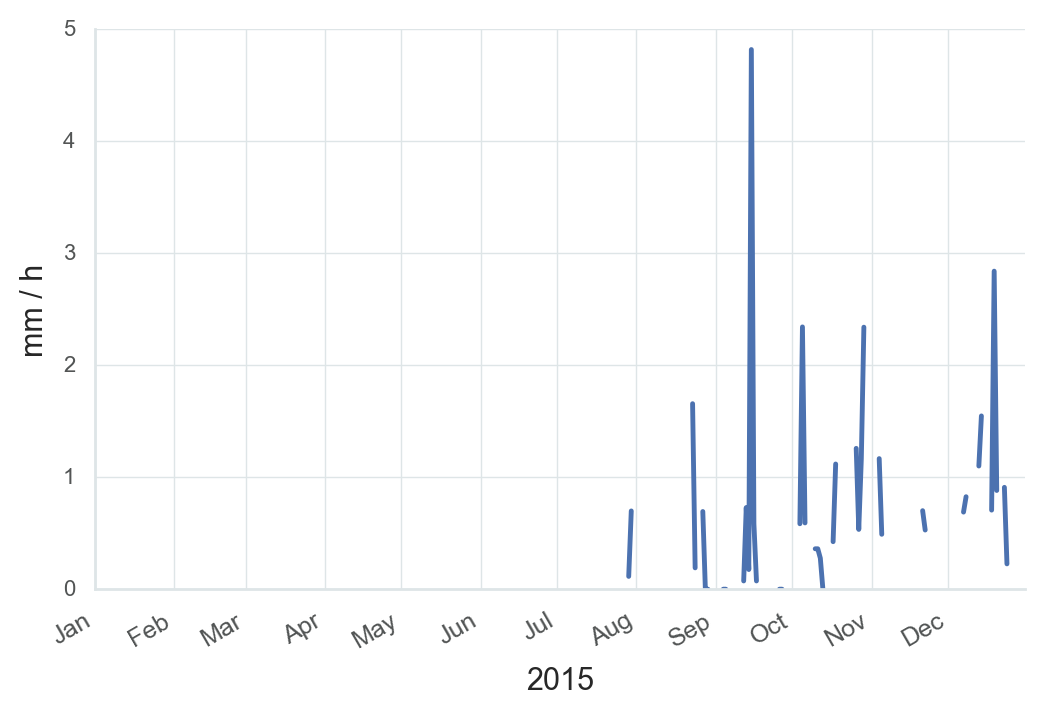

In [7]:
fig, ax = plt.subplots(1)

# visuals
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)  
ax.grid(True)

ax.plot(daily.precipIntensity)
fig.autofmt_xdate() # auto rotate the x labels if needed
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('2015')
ax.set_ylabel('mm / h')
ax.set_xlim([date(2015,1,1),date(2015,12,31)])
plt.show()

We can see that the `precipIntensity` has lots of `NaN` values. If the stations is working properly, those values should actually be `0`. So, in a naive approach (we should actually find a way from the other values to decide if the station was working correctly or not), let's replace all the `NaN` values in `precipIntensity` with `0.`.

In [8]:
# replace NaN values in daily `precipIntensity` with 0.
daily['precipIntensity'].fillna(0., inplace=True)

### Plot the temperature togheter with precipitation

Now let's use double y axis in order to plot the temperature and the precipitation in the same graph.

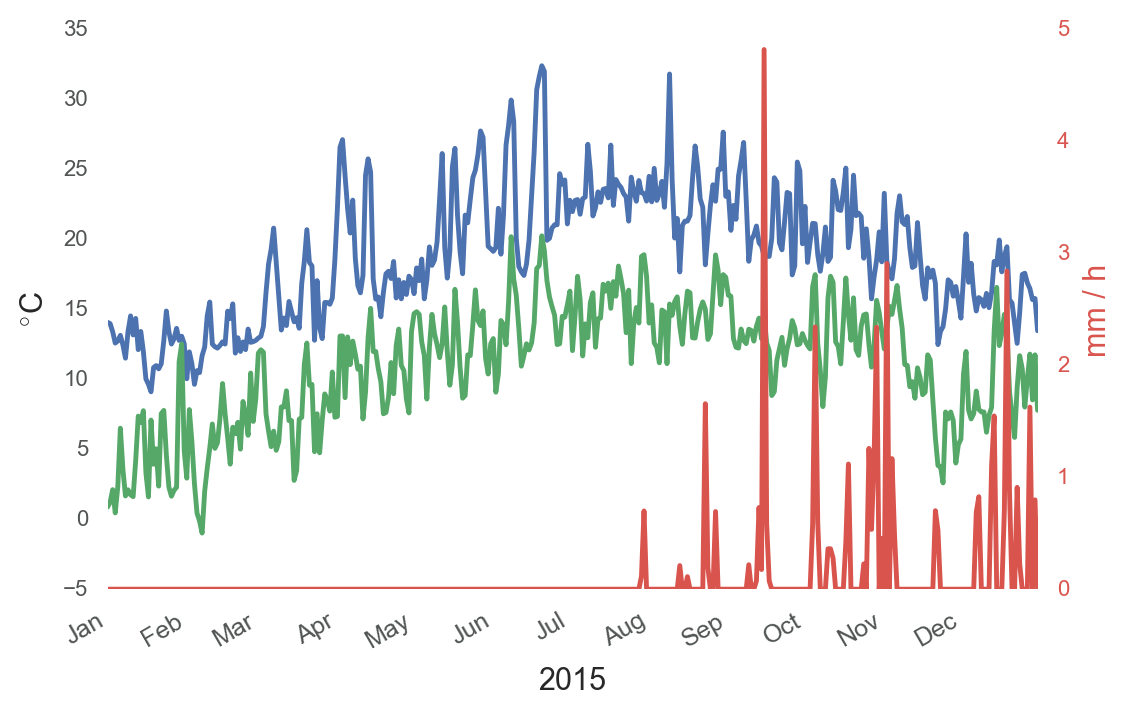

In [9]:
fig, ax1 = plt.subplots(1)
ax1.plot(daily.temperatureMax)
ax1.plot(daily.temperatureMin)
ax1.set_xlim([date(2015,1,1),date(2015,12,31)])
fig.autofmt_xdate() # auto rotate the x labels if needed
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.set_xlabel('2015')
ax1.set_ylabel('$^{\circ}$C')

# visuals ax1
ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  
ax1.grid(False)

ax2 = ax1.twinx()

# visuals ax1
ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  
ax2.grid(False)

ax2.plot(daily.precipIntensity, sns.xkcd_rgb["pale red"])
ax2.set_xlim([date(2015,1,1),date(2015,12,31)])
ax2.set_ylabel('mm / h', color=sns.xkcd_rgb["pale red"])
for tl in ax2.get_yticklabels():
    tl.set_color(sns.xkcd_rgb["pale red"])

plt.show()

## Create the polar plot

In order to create the polar plot of the data several steps are needed:

- Choose the color palete.
- Change the axis labels for `theta` to describe the month.
- Manualy put the axis labels for `r` due to a bug in *maplotlib* that doesn't allow to properly set the `zorder` for axis labels.

### Choose the color palette

- Use *seaborn* to present the color palete and the colors at its extremes and middle point.
- Use the palette values in https://coolors.co and choose a *hue* to use for the axis and text. Use diferent *shades* of this hue for different features.
- Update the relevant `mplstyle` file acordingly. 

#3a54a4 #fffebe #bd1726


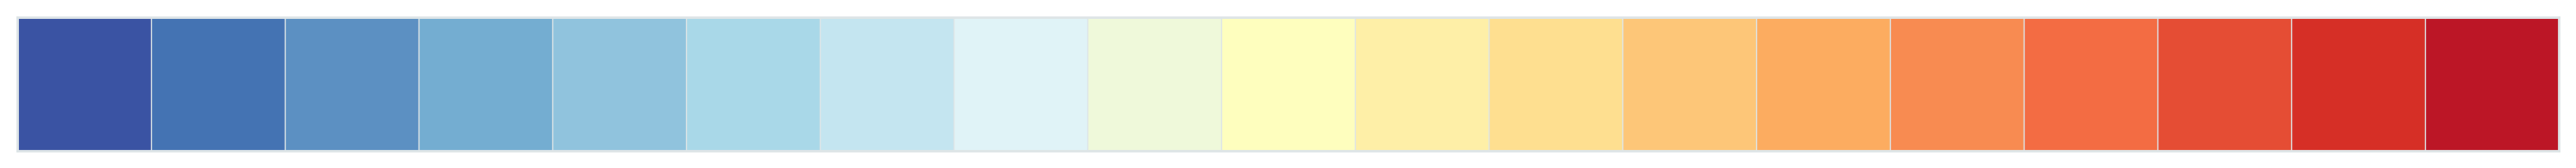

In [10]:
palette = "RdYlBu_r"
size = 19
sns.palplot(sns.color_palette(palette, size))
colors = sns.color_palette(palette, size).as_hex()
print(colors[0], colors[int(size/2)], colors[size-1])

#496aaf #fffebe #b81e48


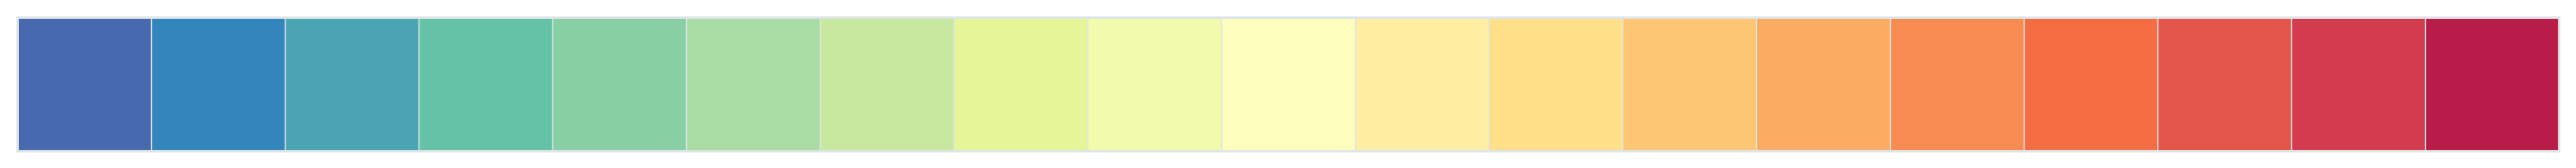

In [11]:
palette = "Spectral_r"
size = 19
sns.palplot(sns.color_palette(palette, size))
colors = sns.color_palette(palette, size).as_hex()
print(colors[0], colors[int(size/2)], colors[size-1])

### Create the polar plot

- Manually create the `theta`, `radii` and `width` lists to use.
- Define a function to manually put the `r` labels in the plot.
- Change the *origin* and *direction* of how `theta` is ploted.
- Change the *angle* labels to the name of the *months*.
- Change the color of the bar according to the average temperature.

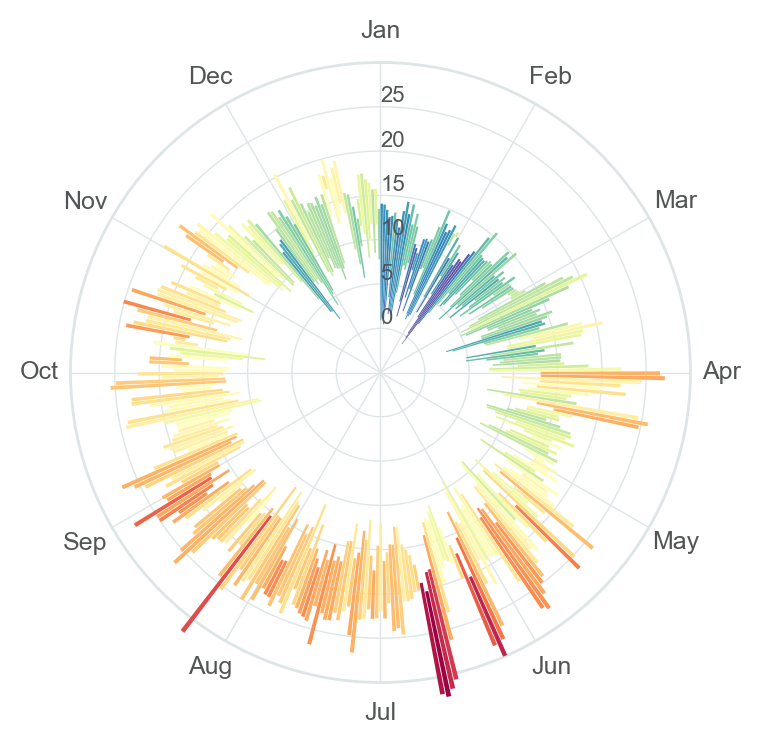

In [12]:
N = len(daily)
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = daily.temperatureMax - daily.temperatureMin
bottom = daily.temperatureMin
width = 0.84*(2*np.pi)/N

max_r = 30
max_atemp = max(daily.temperatureMax+daily.temperatureMin)/2.
min_atemp = min(daily.temperatureMax+daily.temperatureMin)/2.
delta_atemp = max_atemp - min_atemp

def draw_yticks(axes, positions):
    max_r = max(positions)
    for pos in positions:
        label = str(pos)
        ax.text(0.0, pos+max_r*0.02, label, fontsize=8.0, family='sans-serif')

ax = plt.subplot(111, projection='polar')

# set start, direction and limits
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([-5,max_r])

# define the locators
## x
x_pos_list = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
ax.xaxis.set_major_locator(ticker.FixedLocator((x_pos_list)))
ax.axes.yaxis.set_ticklabels([])
name_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.xaxis.set_major_formatter(ticker.FixedFormatter((name_list)))
## y
y_pos_list = range(0, 30, 5)
ax.yaxis.set_major_locator(ticker.FixedLocator((y_pos_list)))
draw_yticks(ax, y_pos_list)

# draw bars
bars = ax.bar(theta, radii, width=width, bottom=bottom, zorder=3, clip_on=False)

# Use custom colors and opacity
# TODO: should use average or median temperature to determine color
for r, bar in zip((daily.temperatureMax + daily.temperatureMin)/2., bars):
    temp_var = (r - min_atemp)/delta_atemp
    # bar.set_facecolor(plt.cm.RdYlBu_r(temp_var))
    bar.set_facecolor(plt.cm.Spectral_r(temp_var))
    bar.set_linewidth(0.0)
    # bar.set_alpha(1.)

plt.show()